# Notebook for the reproduction of results in [Randomized Linear Gate Set Tomography](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.030328).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import my own modules
from src import quantum_utilities as qu
from src import randomized_linear_gst as rlgst

# Import Qiskit basics
from qiskit import QuantumCircuit
from qiskit import Aer, transpile, execute
from qiskit.tools.visualization import plot_histogram

# Import from QiskitAer noise module
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error, amplitude_damping_error, coherent_unitary_error
from qiskit.providers.aer.noise import depolarizing_error

# Import Quantum Information module
import qiskit.quantum_info as qi


## Build noise model

Define initial parameters for you QC system and the error model, as well as the error magnitude.

In [2]:
num_qubits = 1
d2 = 2**(2*num_qubits)
native_gate_list = ['I', 'Xpi2', 'Ypi2']

error_scale = 1*(10**(-4))


rng = np.random.default_rng(2703)


# create list of native gate operations as numpy array
Xpi2 = qu.get_rotation_gate(np.pi/2,'x')
Ypi2 = qu.get_rotation_gate(np.pi/2,'y')
native_gate_op = [np.eye(2), Xpi2, Ypi2]
native_gate_channels = [qu.gate_to_channelmatrix(G) for G in native_gate_op]


def noise_model(e_vec):
    NM = np.eye(4)
    NM = np.dot(qu.get_rotation_channel(e_vec[6],'z'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[5],'y'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[4],'x'),NM)
    NM = np.dot(qu.get_Pauli_channel2(e_vec[1],e_vec[2],e_vec[3]),NM)
    NM = np.dot(qu.get_AD_channel2(e_vec[0]),NM)
    return(NM)

noisy_native_gate_channels = [noise_model(rng.random(7)*error_scale)@gate for gate in native_gate_channels]



def linear_noise_model(e_vec):
    return( np.eye(4) + np.vstack( (np.zeros((1,4)), e_vec.reshape(3,4) )   ) )


# noisy_native_gate_channels = [linear_noise_model(rng.random(12)*error_scale)@gate for gate in native_gate_channels]


In [3]:
print('AGsI:')
print(np.real(qu.AGsI(native_gate_channels, noisy_native_gate_channels)))

AGsI:
0.00011382822564835286


Now we will setup initial state and measurement error. Notice that, chosing as POVM $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(X + Y - Z)$ will only affect the measurement in Z basis as $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(- Z)$, i.e. with a mis-reading equal to $\frac{a}{\sqrt{2}}$ for both $P(1|0)$ and $P(0|1)$.

In [4]:
# build initial state \rho_in and POVMs
a = 0.01

rho_in = np.array([[1, 0],[0, 0]], dtype = np.complex_) + a/np.sqrt(2) * ( qi.Pauli('X').to_matrix() + qi.Pauli('Y').to_matrix() - qi.Pauli('Z').to_matrix())

P0 = rho_in # set measurement POVM
P1 = np.array([[1, 0],[0, 1]], dtype = np.complex_) - P0

rho_dirac = qu.superket(rho_in)
P0_dirac = qu.superbra(P0)

## Sample circuits of intrest

Each circuit will be a list of integers from $1$ to $|\mathcal{G}|$. They will be then arranged into a list of lists, grouping per depth.
NOTE: duplicate circuits have to be discarded.

In [5]:
L_list = [8, 16, 32, 64, 128]
#L_list = [8,16,32]
Nc = 150
#Nc = 24
Nshots = 8192


circuit_list = []
circuit_list.append([])
for l in range(len(L_list)):
    circuits = []
    for i in range(Nc):
        c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist() 
        while c in circuits:
            c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist()
        circuits.append(c)
    circuit_list.append(circuits)

    
Nc_tot = 1 + len(L_list)*Nc
L_list = [0] + L_list


## Compute $\tilde{p}$ and $p$ and build $\mathbf{C}$
Ideal probabilities can be retrived from the same method that builds $\mathbf{C}$. Noisy probabilities have to be simulated apart.

In [6]:
p_noisy = np.zeros((Nc_tot,1))
p_true = np.zeros((Nc_tot,1))
ne_param = len(native_gate_channels)*d2*(d2-1)+2*d2-1
C = np.zeros((Nc_tot, ne_param))

j = 1
p_noisy[0] = qu.my_braket([P0_dirac,rho_dirac]) # null circuit
C[0],p_true[0] = rlgst.get_C_coeff([],native_gate_channels)


for l in range(1,len(L_list)):
    for c in circuit_list[l]:
        C[j],p_true[j] = rlgst.get_C_coeff(c,native_gate_channels)
        gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
        gate_list.insert(0,P0_dirac)
        gate_list.append(rho_dirac)
        p_noisy[j] = np.round(qu.my_braket(gate_list)*Nshots)/Nshots
        j+=1    


In [7]:
print(np.finfo(float).eps)
print(C[0:5])
print(C[55:60])
print(C[-5:])

2.220446049250313e-16
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.07106781e-01  7.07106781e-01
   0.00000000e+00  0.00000000e+00  7.07106781e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  1.00000000e+00 -1.61771350e-16  6.47085399e-16
   3.23542700e-16  3.23542700e-16 -5.23399392e-32  8.71635084e-48
   

## Estimate error $\hat{e}$

In [8]:
# compute C (pseudo)inverse
C_limited = C
tol = 1e-15
C_limited[np.abs(C_limited.real) < tol] = 0.0
#C_limited.imag[abs(C_limited.imag) < tol] = 0.0

V, C_eig, WH = np.linalg.svd(C_limited, full_matrices=False)
threshold = Nc_tot*np.finfo(float).eps*C_eig.max()
print(threshold)

inv_diag = [1/lambda_ if np.abs(lambda_) >= threshold else 0 for lambda_ in C_eig]

C_inv = WH.conjugate().T @ np.diag(inv_diag) @ V.conjugate().T # right inverse of C

# estimate e
e = C_inv@(p_noisy-p_true)


2.875232208712225e-11


In [9]:
print(C_limited[0:5])
print(C_limited[55:60])
print(C_limited[100:105])

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.70710678  0.70710678  0.          0.
   0.70710678]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.5         0.5         0.          0.
   0.          0.          0.         -1.          0.5         0.5
   0.          0.          0.          1.          0.          0.
   0.          0.70710678  0.          0.70710678  0.70710678  0.
   0.        ]
 [ 0.          0.          0.          0.    

Analyze $\mathbf{C}$ matrix.

In [10]:
print(C_eig)
print(inv_diag)
print(e.T)

[1.72422033e+02 7.37289268e+01 5.21309087e+01 4.37988984e+01
 3.87309692e+01 3.79714531e+01 3.48313309e+01 3.31907392e+01
 3.19842024e+01 2.98797747e+01 2.73916329e+01 2.60663232e+01
 2.55453041e+01 2.32613020e+01 2.16006338e+01 2.08736813e+01
 2.01948566e+01 1.96106279e+01 1.83681746e+01 1.78146745e+01
 1.72086861e+01 1.68742397e+01 1.59454836e+01 1.58202726e+01
 1.55406158e+01 1.55089522e+01 1.32460426e+01 1.19876900e+01
 1.12551817e+01 1.09807898e+01 1.06965295e+01 7.65707645e-14
 1.15586931e-14 1.15586931e-14 1.15586931e-14 1.15586931e-14
 1.15586931e-14 1.15586931e-14 1.15586931e-14 1.15586931e-14
 1.15586931e-14 1.15586931e-14 9.62940522e-15]
[0.005799722811723297, 0.01356319755574207, 0.01918247780534524, 0.02283162445812181, 0.025819131855162016, 0.026335573624608893, 0.028709784397005066, 0.03012888605022724, 0.031265435008864605, 0.03346745452530722, 0.0365074985466626, 0.03836367689130447, 0.03914613795844838, 0.042989855045404285, 0.04629493795230917, 0.047907217961646265, 

Extract noisy maps from $e$.

In [11]:
#err_list = []
est_noisy_gate_channels = []

for i in range(len(native_gate_channels)):
    e_i = np.eye(4) + np.vstack(( np.zeros((1,4)), e[i*12:(i+1)*12].reshape(3,4)))
    #err_list.append(e_i)
    est_noisy_gate_channels.append(e_i@native_gate_channels[i])
    
rho_est = rho_dirac +  np.vstack( (np.array([0]), e[len(native_gate_channels)*12:len(native_gate_channels)*12+3]) )
P0_est = P0_dirac + e[len(native_gate_channels)*12+3:].conjugate().T

## Run test-set circuits

In [12]:
L_test_list = [10, 50, 100, 200, 500, 1000]
Nc_test = 1000

Nc_test_tot = len(L_test_list)*Nc_test

N_it = 10

delta = np.zeros((N_it,len(L_test_list)))

for it in range(N_it):
    delta_it = []
    circuit_test_list = []
    for l in range(len(L_test_list)):
        circ = [rng.integers(low=0, high= len(native_gate_list), 
                             size=L_test_list[l]).tolist() for i in range(Nc_test)] 

        p_test_true_l = np.zeros((Nc_test,1))  # true noisy p
        p_test_est_l = np.zeros((Nc_test,1)) # estimated p
        j = 0
       
        for c in circ:
            true_gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
            true_gate_list.insert(0,P0_dirac)
            true_gate_list.append(rho_dirac)

            est_gate_list = [est_noisy_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list.insert(0,P0_est)
            est_gate_list.append(rho_est)

            p_test_true_l[j] = np.round(qu.my_braket(true_gate_list)*Nshots)/Nshots
            p_test_est_l[j] = np.round(qu.my_braket(est_gate_list)*Nshots)/Nshots
            j+=1 
        
        delta_it.append(np.linalg.norm((p_test_true_l - p_test_est_l),ord=1)/Nc_test)
    print(delta_it)
    delta[it] = np.array(delta_it)


delta_mean = np.mean(delta,axis=0)


[0.0092132568359375, 0.008822265625, 0.0089383544921875, 0.0087176513671875, 0.0088193359375, 0.0107490234375]
[0.008930908203125, 0.008708740234375, 0.008784912109375, 0.00886767578125, 0.0087630615234375, 0.0109085693359375]
[0.0089921875, 0.0084825439453125, 0.0086995849609375, 0.008883544921875, 0.008714111328125, 0.0108763427734375]
[0.008896728515625, 0.008828369140625, 0.0087232666015625, 0.00890380859375, 0.00874267578125, 0.0104710693359375]
[0.0090614013671875, 0.00876171875, 0.0089019775390625, 0.00893017578125, 0.00885888671875, 0.0104951171875]
[0.0093858642578125, 0.0089898681640625, 0.0085703125, 0.00861181640625, 0.0088848876953125, 0.0106253662109375]
[0.0088016357421875, 0.00909912109375, 0.008798828125, 0.0090750732421875, 0.0085245361328125, 0.0102652587890625]
[0.0092275390625, 0.0092547607421875, 0.0086810302734375, 0.0088699951171875, 0.008939453125, 0.010517822265625]
[0.009130126953125, 0.0087093505859375, 0.008992919921875, 0.008516845703125, 0.008921752929687

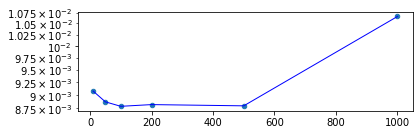

In [13]:
plt.figure()
plt.subplot(211)
plt.plot(L_test_list, delta_mean, 'b', lw=1)
plt.scatter(L_test_list, delta_mean, s=20)
plt.yscale("log")
plt.show()

# Standard GST section

In [14]:
import pygsti
from pygsti.circuits import Circuit
from pygsti.circuits.circuitparser import CircuitParser
from pygsti.models import Model
from pygsti.data import DataSet
from pygsti.modelpacks import smq1Q_XYI
import pygsti.modelmembers as mm

In [15]:
#Initialize an empty Model object
#Designate the basis being used for the matrices and vectors below 
# as the "Pauli product" basis of dimension 2 - i.e. the four 2x2 Pauli matrices I,X,Y,Z
mdl_noisy = pygsti.models.ExplicitOpModel((0,),'pp')

#Populate the Model object with states, effects, gates,
# all in the *normalized* Pauli basis: { I/sqrt(2), X/sqrt(2), Y/sqrt(2), Z/sqrt(2) }
# where I, X, Y, and Z are the standard Pauli matrices.
mdl_noisy['rho0'] = rlgst.flatten(rho_dirac) # noisy init density matrix
mdl_noisy['Mdefault'] = mm.povms.UnconstrainedPOVM(
    {'0': rlgst.flatten(P0_dirac),   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': rlgst.flatten(qu.superket(P1)) },# projector onto [[0, 0], [0, 1]] in Pauli basis
    evotype='densitymx') # Specify the evolution type when initializing from NumPy arrays.
                         # densitymx is the default

mdl_noisy['Gi'] = noisy_native_gate_channels[0].tolist() # 4x4 identity matrix, noisy
mdl_noisy['Gx'] = noisy_native_gate_channels[1].tolist() # pi/2 X-rotation in Pauli basis, noisy
mdl_noisy['Gy'] = noisy_native_gate_channels[2].tolist() # pi/2 Y-rotation in Pauli basis, noisy

In [26]:
print(rlgst.flatten(rho_dirac))


[0.7071067811865475, 0.009999999999999998, 0.009999999999999998, 0.6971067811865475]


In [19]:
# 1) get the target Model
mdl_ideal = smq1Q_XYI.target_model()


# 2) get the building blocks needed to specify which circuits are needed
prep_fiducials, meas_fiducials = smq1Q_XYI.prep_fiducials(), smq1Q_XYI.meas_fiducials()
germs = smq1Q_XYI.germs()

maxLengths = [1,2,4]
lsgst_lists = pygsti.circuits.create_lsgst_circuit_lists(mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

listOfExperiments = pygsti.circuits.create_lsgst_circuits(mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)


In [20]:
ds = pygsti.data.simulate_data(mdl_noisy, listOfExperiments, num_samples=8192,
                                            sample_error="binomial", seed=2703)

KeyError: 'Cannot create operator for label `Gxpi2:0` from factories. Maybe you forgot the args?'

In [ ]:
def convert_circuit(gst_c, germ_list):
    # I am assuming first 3 element of the germ list are the native gates (can I ???)
    my_c = [] 
    for i in range(len(c)):
        if c[i] == germ_list[0][0]:
            my_c += [0]
        elif c[i] == germ_list[1][0]:
            my_c += [1]
        elif c[i] == germ_list[2][0]:
            my_c += [2]
        else:
            my_c += [-1] # error flag
    
    return(my_c)

def build_gst_experiment_list(lsgst_lists,germs):
    circuit_lists = []
    label_lists = []
    for i,lst in enumerate(lsgst_lists):
        circuit_lists.append([convert_circuit(c,germs) for c in lst])

In [ ]:

for i,lst in enumerate(lsgst_lists):
    print("\nList %d (max-length L=%d): %d Circuits" % (i,maxLengths[i],len(lst)))
    #print('\n'.join([c.str for c in lst]))
    for c in lst:
        print(c)
        print(convert_circuit(c,germs ) )


In [ ]:
#exp_design = pygsti.protocols.StandardGSTDesign(mdl_ideal, prep_fiducials, meas_fiducials,
#                                                germs, maxLengths)


# 3) generate data
#listOfExperiments = pygsti.circuits.create_lsgst_circuits(
#    mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

#Note: from listOfExperiments we can also create an empty dataset file
# which has columns of zeros where actual data should go. 
#pygsti.io.write_empty_dataset("../data/test_dataset.txt", listOfExperiments,
#                              "## Columns = 0 count, 1 count")

# After replacing the zeros with actual data, the data set can be 
# loaded back into pyGSTi using the line below and used in the rest
# of this tutorial. 
#ds = pygsti.io.load_dataset("tutorial_files/GettingStartedDataTemplate.txt")